In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
a = np.random.randn(1000)
b = np.random.randn(1000)
x = 2*a + 1
y = -2*a + b

### Measuring Rings

In notebook we will measure the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters. 

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, we would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters. 

As an example, a real strong lensing image looks like this:

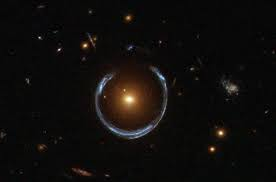

So now we define our "simulator."

In [3]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    
    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)
    
    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

In [4]:
radius = 0.5
sigma = 0.3
width = 0.15
n = 1
x = np.linspace(-2, 2, 32)
X, Y = np.meshgrid(x, x)

# Random position of the ring
imgs = []
for i in range(n):
  x0, y0 = np.random.uniform(-1, 1, 2)

  R = ((X-x0)**2 + (Y-y0)**2)**0.5
  img = np.exp(-(R-radius)**2/width**2/2)
  img = img

  imgs.append(img)

# Standard variance and zero mean
img = sum(imgs)

# Remove mean and variance
img -= img.mean()
img /= img.std()

# Add image noise
img += np.random.randn(*img.shape)*sigma

Next, we next generate our training and test data. In this case, 50000 examples.

In [5]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [6]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [7]:
examples = list(test_loader)
example_data, example_targets = examples[0]
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1])


And plot test examples.

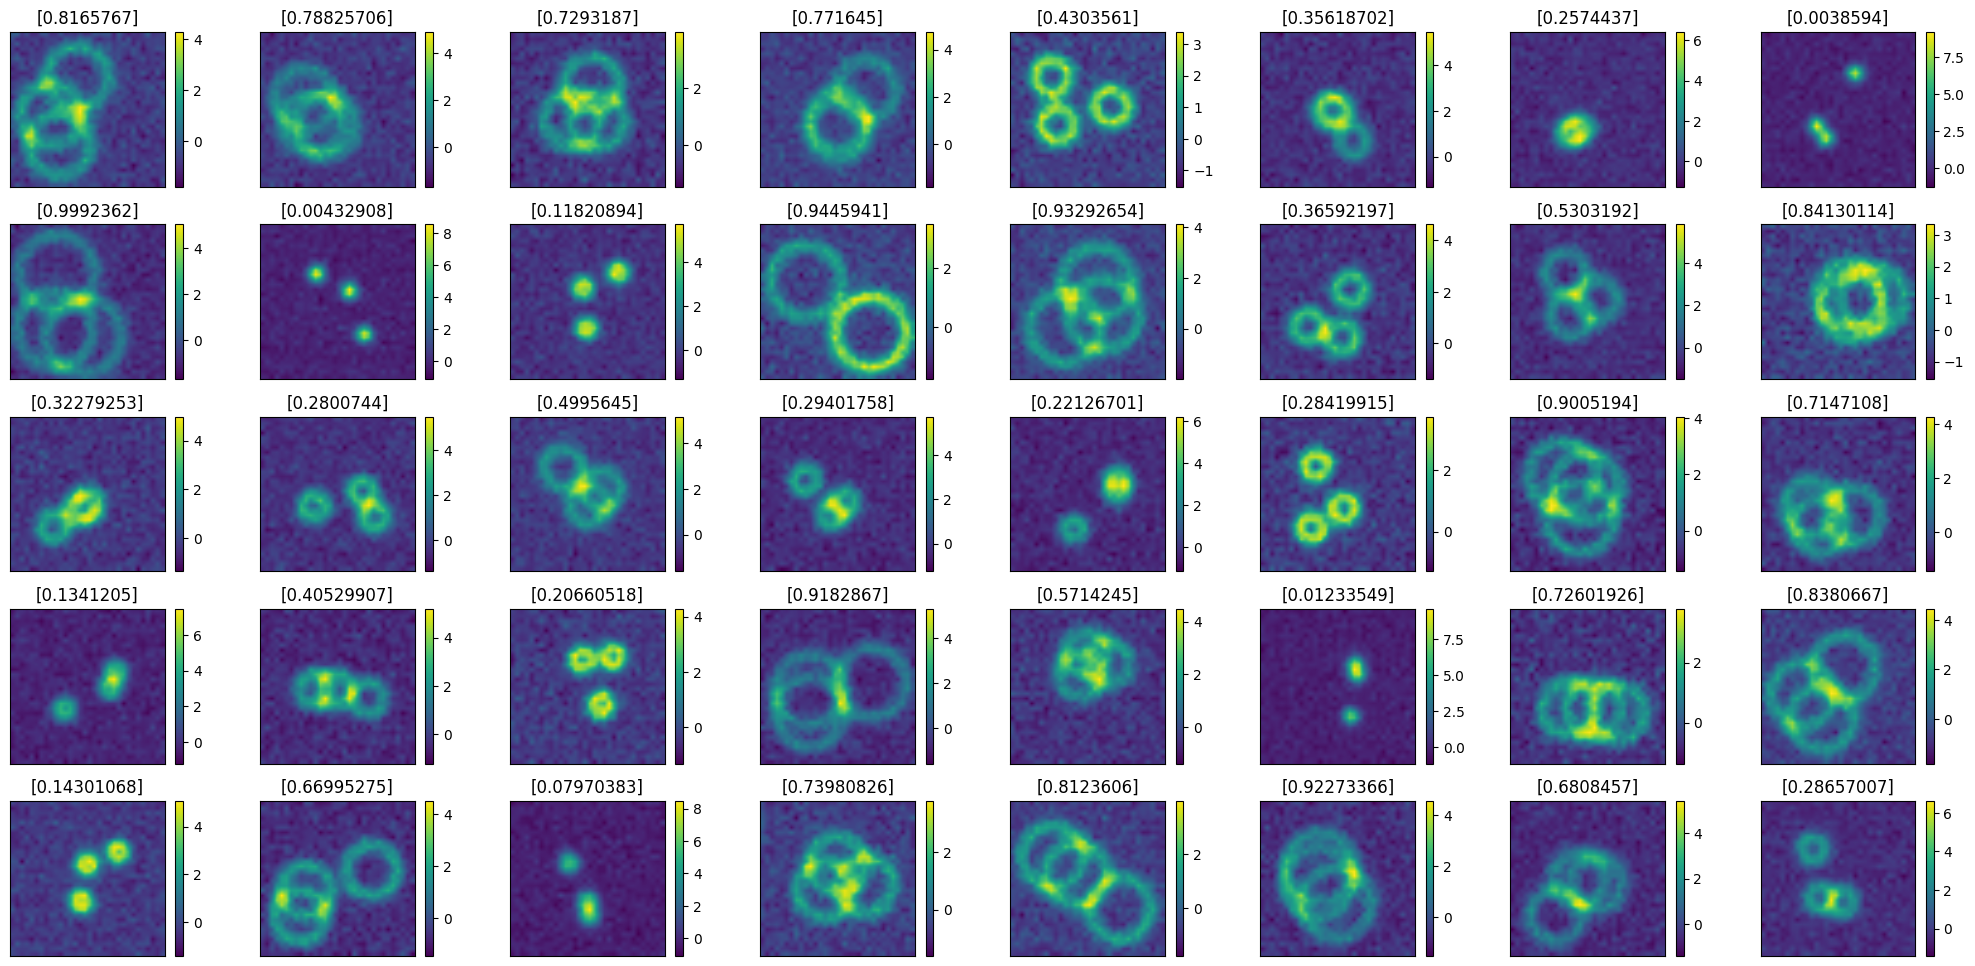

In [8]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='bilinear')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=(2,2))
    self.fc1 = nn.Linear(980, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x)), 2)
    x = x.view(-1, 980)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
    

For classification we use the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression.

In [11]:
torch.cuda.is_available()

True

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [13]:
learning_rate = 0.01

network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [14]:
n_epochs = 3  # 3 epochs by default

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = network(data)
      loss = F.mse_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [16]:
log_interval = 10

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = network(data)
      test_loss += F.mse_loss(output, target, size_average=False).item()
      pred = output#.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}',
        test_loss, correct, len(test_loader.dataset))

Training

In [17]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

TypeError: ignored

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses)
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [ ]:
for data, target in test_loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = network(data)

In [ ]:
x_line = np.linspace(0,1,2)
plt.plot(x_line, x_line, color = 'r', label = '$x = y$')
plt.scatter(target.cpu().detach().numpy(), output.cpu().detach().numpy(), label = 'data', alpha = 0.7)
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.legend()
plt.tight_layout()
plt.savefig(fname = 'q4.png', dpi = 300)
plt.show()

We can see that the network perform really well with small deviations from the $x = y$ line. 

We can see from the plot below in small radii the model performs better as 
the deviation from $x = y$ line is lower. Therefore for smaller rings we obtain predictions with higher confidence, hence smaller error bars. 

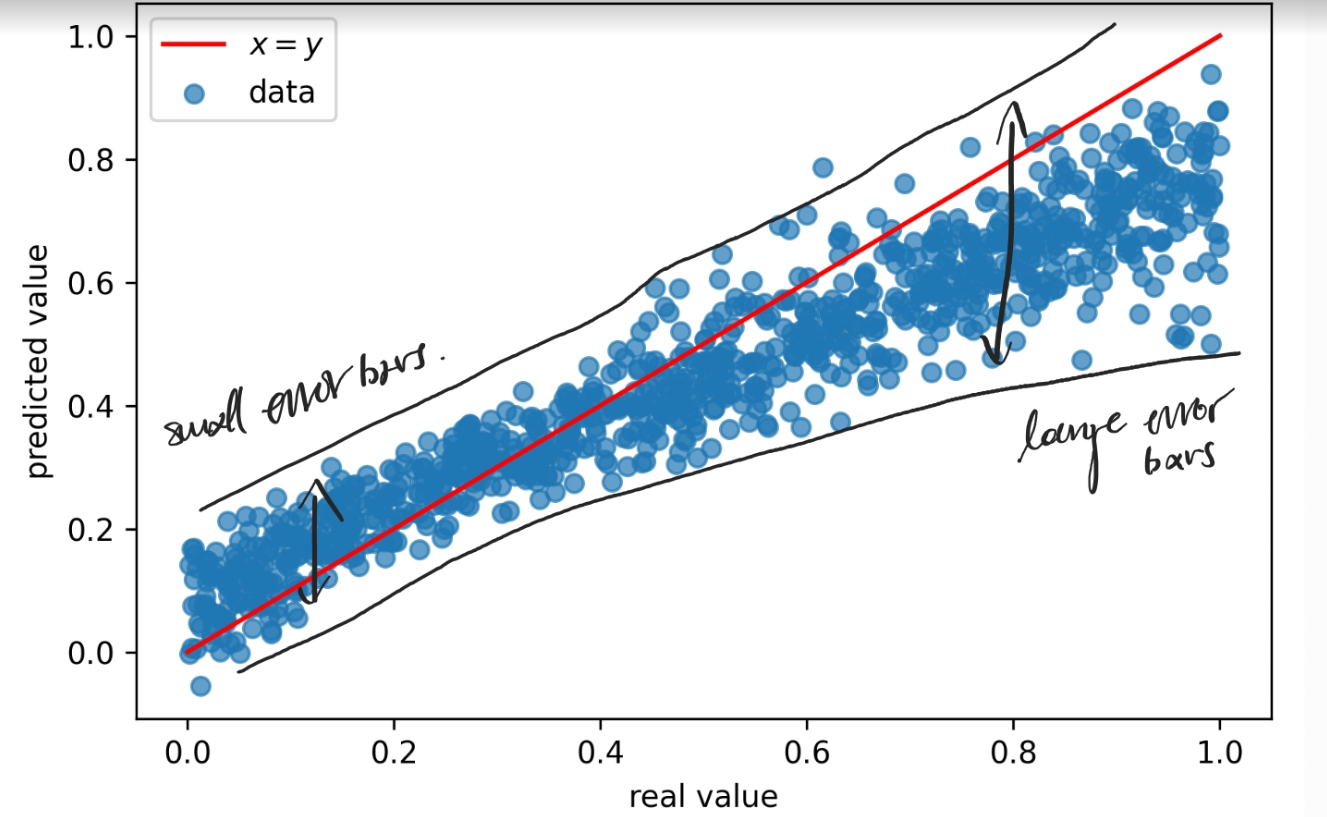

Simulation Based Inference

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

Now we define the optimizer, and instantiate the network.

In [19]:
learning_rate = 0.001
#DEVICE = 'cuda'
network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [20]:
n_epochs = 3  # 3 epochs by default. 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

This is the main training loop is now given as follows.

In [21]:
for batch_idx, (data, target) in enumerate(train_loader):
  optimizer.zero_grad()
  data = data.to(DEVICE)
  target = target.to(DEVICE)

  output_joined = network(data[1:], target[1:])
  output_marginal = network(data[1:], torch.randn_like(target[1:]))

In [22]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.randn_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

The 2 different outputs are the joined and marginal distribution which are used for the computation of the loss function. The mathematical definition is as follows. 

$ L_{loss} = \int_{}^{} ln(p(x,z)) + ln(1-p(x)p(z)) \,dxdz $

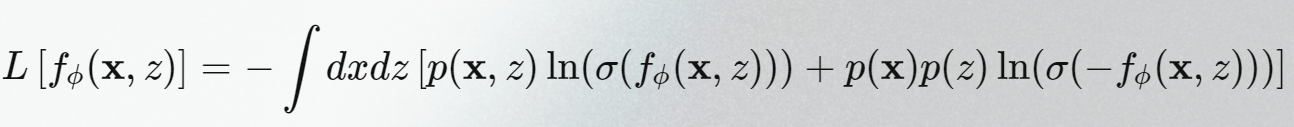

In [23]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 87.450928
Train Epoch: 1 [640/45000 (1%)]	Loss: 86.721687
Train Epoch: 1 [1280/45000 (3%)]	Loss: 86.572281
Train Epoch: 1 [1920/45000 (4%)]	Loss: 85.975227
Train Epoch: 1 [2560/45000 (6%)]	Loss: 85.856964
Train Epoch: 1 [3200/45000 (7%)]	Loss: 84.946671
Train Epoch: 1 [3840/45000 (9%)]	Loss: 82.149284
Train Epoch: 1 [4480/45000 (10%)]	Loss: 83.253082
Train Epoch: 1 [5120/45000 (11%)]	Loss: 81.854370
Train Epoch: 1 [5760/45000 (13%)]	Loss: 79.683594
Train Epoch: 1 [6400/45000 (14%)]	Loss: 82.413605
Train Epoch: 1 [7040/45000 (16%)]	Loss: 81.097534
Train Epoch: 1 [7680/45000 (17%)]	Loss: 76.061928
Train Epoch: 1 [8320/45000 (18%)]	Loss: 77.468811
Train Epoch: 1 [8960/45000 (20%)]	Loss: 82.267685
Train Epoch: 1 [9600/45000 (21%)]	Loss: 76.172798
Train Epoch: 1 [10240/45000 (23%)]	Loss: 79.369545
Train Epoch: 1 [10880/45000 (24%)]	Loss: 77.314354
Train Epoch: 1 [11520/45000 (26%)]	Loss: 71.896271
Train Epoch: 1 [12160/45000 (27%)]	Loss: 71.929352
Train E

In [25]:
def hpd(trace, mass_frac) :

    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

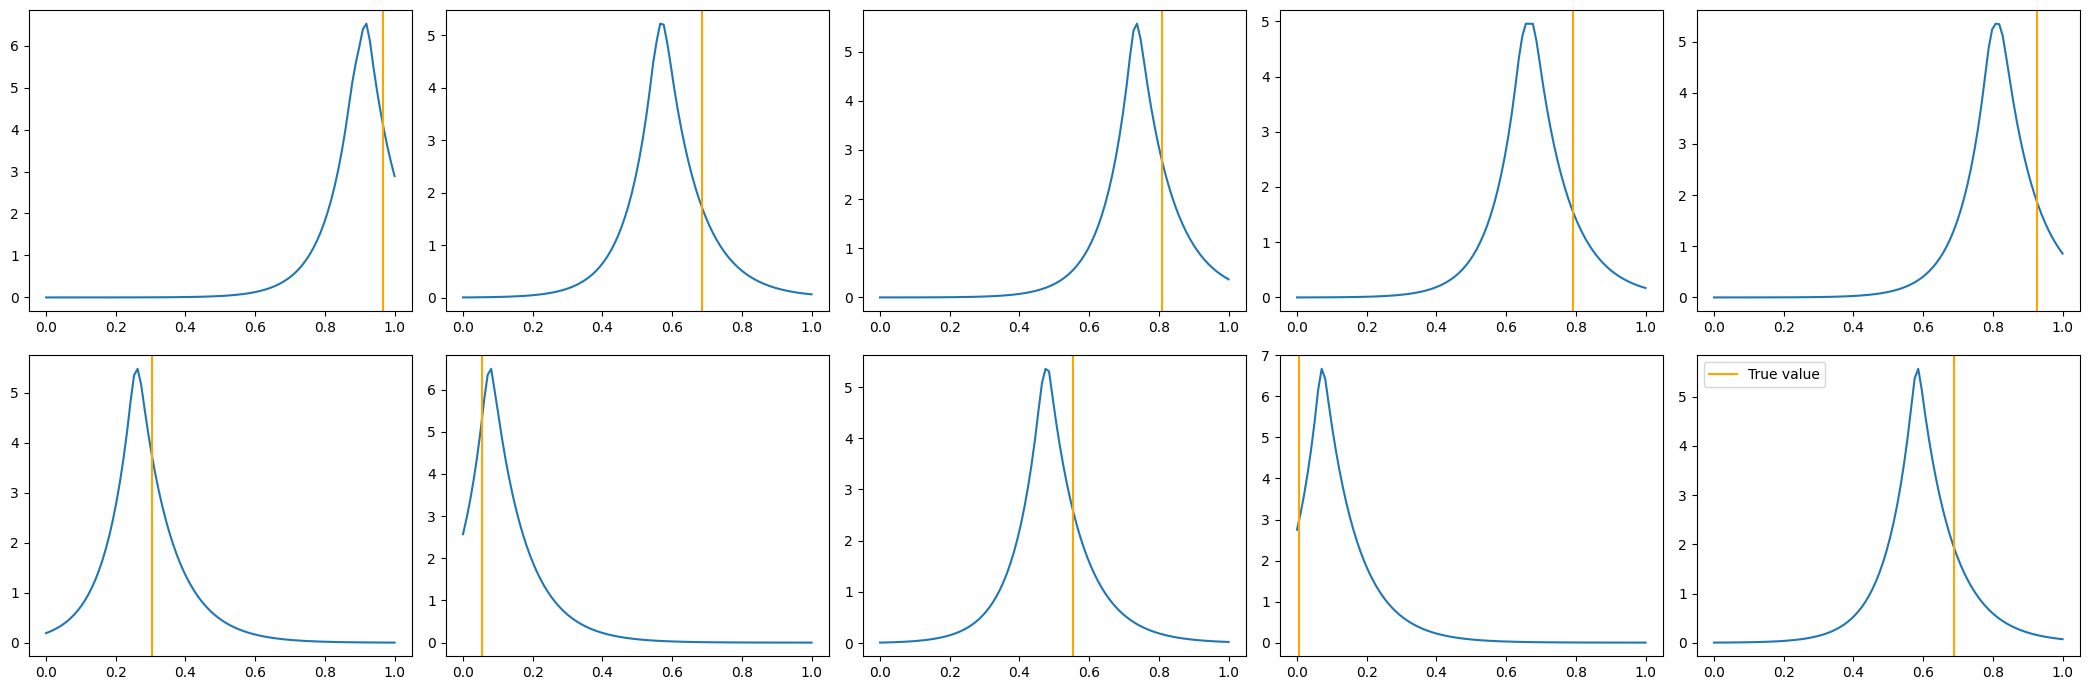

In [31]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
batch_size_test = 1000
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test)#, shuffle=True)
for data, target in test_loader:
    data = data.to(DEVICE)
    target = target.to(DEVICE)

fig2, axs2 = plt.subplots(2,5, figsize = (21,7))
k = 0
for x in range(2):
  for y in range(5):

    z_prior = torch.linspace(0.,1.,100)
    # rate = []
    out = []
    marginal = []
    log_post = []
    for i in z_prior:
      network.eval()
      i = i.to(DEVICE)
      out = network(data[k], i.reshape(1,1))
      log_post.append(np.log(1/out.cpu().detach().numpy()[0] - 1))
    
    out = out.cpu().detach().numpy()

    # Get posterior
    log_post = np.array(log_post)
    p = np.exp(-log_post[:,0])

    # Divide by the integral to normalize
    integral = np.trapz(p, z_prior.cpu())
    p /= integral

    axs2[x,y].plot(z_prior.cpu(), p) 
    axs2[x,y].axvline(x = target[k].cpu().detach().numpy(), color = 'orange', label = 'True value')

    k += 10

plt.legend()
plt.tight_layout()
plt.show()

For each image in the test dataset we derive a posterior. Next, since our test dataset contains 1000 examples, we calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly we visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. 



0
100
200
300
400
500
600
700
800
900
72.0 % of the true radii lies within 68% CL


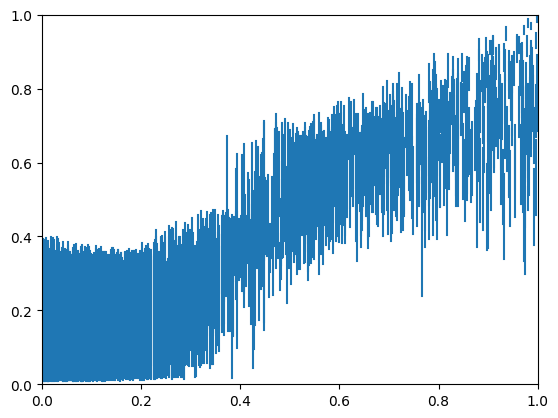

In [32]:
count = 0
for c in range(1000):
  if c % 100 ==0:
    print(c)
  z_prior = torch.linspace(0,1,100)
  out = []
  for i in z_prior:
    network.eval()
    i = i.to(DEVICE)
    output_joined = network(data[c], target[c].reshape(1,1))
    output_marginal = network(data[c], i.reshape(1,1))
    rate = output_joined/output_marginal
    out.append((rate*i).cpu().detach().numpy())

  out = np.array(out).reshape(100,)


  out = np.array(out).reshape(100,)
  mask2 = out>0
  out = out[mask2]
  mask = out<1
  out = out[mask]
  c1, c2 = hpd(out, 0.68)


  target_temp = target[c].cpu().detach().numpy()
  plt.axvline(x = target_temp, ymin=c1, ymax=c2)

  if target_temp>c1 and target_temp<c2:
    count += 1

print(count/10, '% of the true radii lies within 68% CL')


Now we repeat part of the previous exercise for 95% and 99% credible intervals and we estimate the fraction of training data examples where the true value is contained in the credible interval.


In [33]:
count = 0
count99 = 0
for c in range(1000):
  z_prior = torch.linspace(0,1,100)
  out = []
  for i in z_prior:
    network.eval()
    i = i.to(DEVICE)
    output_joined = network(data[c], target[c].reshape(1,1))
    output_marginal = network(data[c], i.reshape(1,1))
    rate = output_joined/output_marginal
    out.append((rate*i).cpu().detach().numpy())

  out = np.array(out).reshape(100,)

  out = np.array(out).reshape(100,)
  mask2 = out>0
  out = out[mask2]
  mask = out<1
  out = out[mask]
  c1, c2 = hpd(out, 0.95)

  target_temp = target[c].cpu().detach().numpy()
  # plt.axvline(x = target_temp, ymin=c1, ymax=c2)

  if target_temp>c1 and target_temp<c2:
    count += 1

  c1, c2 = hpd(out, 0.99)


  target_temp = target[c].cpu().detach().numpy()
  # plt.axvline(x = target_temp, ymin=c1, ymax=c2)

  if target_temp>c1 and target_temp<c2:
    count99 += 1

print(count/10, '% within 95% CL')
print(count99/10, '% within 99% CL')

94.4 % within 95% CL
96.8 % within 99% CL


We can see that approximately 95% and 97% of the true radius lies in 95% and 99% CL respectivelly. This is a good prediction for our model which mean that our model it's not overfitting or perform badly. 